# Wstęp do uczenia maszynowego - Projekt 1
## Aleksander Malinowski | Damian Skowroński
___
### Milestone 2
Będziemy robić modele na danych, na których wykonaliśmy preprocessing w kamieniu milowym 1. W preprocessingu wykonaliśmy następujące zmiany:

*   dodatnie kolumn:
    *   _black_king_dst_ - odleglość czarnego króla od brzegu planszy
    *   _black2white_king_dst_ - odległość króli od siebie 
    *   _black2rook_dst_ - odległość czarnego króla od białej wieży
*   wykonanie label encoding dla zmiennych określających _file_
*   zamienienie wartości słownych w zmiennej celu _result_ na odpowiadające im liczby i wartości "draw" na "-1"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')

#df = pd.read_csv("training_set.csv", index_col=0).reset_index(drop=True)
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/WUM_Proj1/training_set.csv', index_col=0).reset_index(drop=True)

df.head()

Mounted at /content/drive


,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
0,2,2,3,3,8,3,13,0,6,5
1,1,1,6,3,5,3,-1,2,4,1
2,4,4,7,5,8,2,6,0,4,3
3,3,1,7,3,2,7,13,1,6,5
4,4,1,2,5,8,5,13,0,4,6


Podział na zbiór treningowy i walidacyjny

Podchodzimy do problemu przewidzenia rezultatu w następujący sposób:

1.  klasyfikacja, czy doszło do remisu "draw" (u nas wartość "-1"), czy nie (dowolna inna wartość)
2. regresja w celu przewidzenia ilości ruchów, dla wyników, które w pierwszym kroku zostały sklasyfikowane, że gra nie skończyła się remisem



### Klasyfikacja 

#### Remisy
Remisy nam bardzo przeszkadzają w dalszej regresji więc postaramy się je przewidzieć w inny sposób i całkowicie je pominąć przy regresji.

Ponieważ zbiór danych teoretycznie przedstawia optymalne ruchy, a przewaga białego nad czarnym jest duża, remis zachodzi zapewne w jednej z dwóch sytuacji:
    1. czarny bije białą wieżę
    2. stalemate - czarny nie ma gdzie się ruszyć
    
    
##### 1. Czarny bije białą wieżę 
Taka sytuacja zdaży się w momencie, gdy czarny król jest w odległości od białej wieży równej "1", a biały król jest w odległości od białej wieży większej niż "1". W tym celu tworzymy nową zmienną _white2rook_dst_, której nie braliśmy pod uwagę w preprocessingu (możliwe, że przyda się też potem w regresji).

In [2]:
def white2rookdistance(df):
     # dystans pomiędzy białym królem i wieżą
    return max(abs(df['white_king_file'] - df['white_rook_file']),abs(df['white_king_rank'] - df['white_rook_rank']))

Następnie ze otrzymanej nowej zmiennej _white2rook_dst_ i wcześniejszej _black2rook_dst_ mogę dowiedzieć się czy czarny zbije wieżę.

In [3]:
def w2r_rt(df): 
    #white to rook distance + rook taken
    df['white2rook_dst'] = df.apply(lambda x: white2rookdistance(x), axis = 1)
    df["rook_taken"] = np.where(
        (df.black2rook_dst == 1) & (df.white2rook_dst != 1),
        1,0)

Sprawdzając korelację pomiędzy nową zmienna _rook_taken_, a result w wersji remis/nieremis otrzymujemy następujący wynik:

In [4]:
w2r_rt(df)
np.corrcoef(df.rook_taken,df.result.apply(lambda x: 1 if x == -1 else 0))   # rook_taken == 0, oznacza, że wieża będzie zbita, a tu result == 0 będzie oznaczał, że jest remis

array([[1.        , 0.99858054],
       [0.99858054, 1.        ]])

Wychodzi, że korelacja jest bardzo duża.

In [5]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.rook_taken,df.result.apply(lambda x: 1 if x == -1 else 0))

array([[17682,     5],
       [    0,  1952]])

Okazuje się, nowa zmienna prawie dokładnie opisuje sytuacje i popełniła tylko 5 błędów, gdy nie znajduje remisu.

*po mielstone 2*

##### 2. Stalemate
W tym przypadku wystąpi w następujących sytuacjach:

![pat1.jpg](attachment:pat1.jpg)

Pierwsza sytuacja wystąpi jeśli wieża jest w dowolnym miejsu oprócz w kolumnie "a" w drugim rzędzie. Również w takiej samej sytuacji, ale dla lustrzanego odbicia wzdłuż diagonali idącej z lewego dolnego rogu do prawego górnego. Oczywiście też podobnie dla każdego rogu. 

Inaczej mówiąc jest to sytuacja, gdy jednocześnie:

* czarny król jest na granicy planszy, 
* biały król jest w tym samym rzędzie/kolumnie co czarny król
* odległość króli między sobą wynosi $2$
* biała wieża jest przesunięta o odpowiednio jeden rząd/kolumnę od granicy planszy
* biała wieża nie jest w tej samej kolumnie/rzędzie co czarny król, żeby nie mógł jej zbić (ta sytuacja i tak jest remisem, więc nie trzeba tego warunku brać pod uwagę)
  

![pat3.jpg](attachment:pat3.jpg)

Druga sytuacja wystąpi tylko po 5 razy (w czym 2 znich pokrywają się z pierwszą sytuacją) w każdym rogu. Bo biały król może być na jednym z pięciu możliwych pól obok wieży.

Dzieje się to przy następujących warunkach:

* czarny król jest w samym rogu
* biała wieża jest na diagonali oddalona od czarnego króla o 1
* biały król musi być przy białej wieży (nie jest to ważny warunek, bo jeśli nie jest przy niej to i tak jest remis i wcześniej bierzemy to pod uwagę)

In [6]:
def drawed(df):    
    df["is_draw"] = np.where(
        ((df.black2rook_dst == 1) & (df.white2rook_dst != 1)) |      # czarny bije wieze
        ((df.black_king_dst == 0) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & (df.black2white_king_dst == 2) & (((df.white_king_file == df.black_king_file) & (np.abs(df.white_rook_file - df.black_king_file) == 1)) | ((df.white_king_rank == df.black_king_rank) & (np.abs(df.white_rook_rank - df.black_king_rank) == 1)))) |  # pierwsza sytuacja
        ((df.black_king_dst == 0) & (df.black2rook_dst == 1) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & (((np.abs(df.white_rook_file - df.white_rook_rank)) == 0) |  ((np.abs(df.white_rook_file - df.white_rook_rank)) == 7))), # druga sytuacja
        1,0) # znowu jest na odwrót 0 oznacza, że tak a 1 że nie
    return df
df = drawed(df)

In [7]:
confusion_matrix(df.is_draw,df.result.apply(lambda x: 1 if x == -1 else 0))

array([[17682,     0],
       [    0,  1957]])

W ten sposób możemy przewidzieć każdy ramis/nieremis prawidłowo.

#### 0 ruchów do mata 
Wydaje się że można też jednoznacznie powiedzieć, kiedy mat już jest, czyli w zmiennej result jest wartość $0$. Sytuacja wygląda tak:

![mat0.jpg](attachment:mat0.jpg)

lub rzadziej tak:

![mat2.jpg](attachment:mat2.jpg)

Inaczej można powiedzieć, że jednocześnie:

* czarny król jest na krawędzi planszy
* odległość między królami jest równa 2
* wieża nie jest zbijana (nie ma remisu)
* wieża jest w tej samej kolumnie/rzędzie co czarny król
* biały król jest odpowiednio w tym samym rzędzie/kolunie co czarny król


In [8]:
def mated(df):
    df["is_mated"] = np.where(
        (df.black_king_dst == 0) & (df.black2white_king_dst == 2) & (df.is_draw == 0) & ((((df.black_king_file == df.white_rook_file) & (df.black_king_rank == df.white_king_rank) & ((df.black_king_file == 1) | (df.black_king_file == 7)))) | ((df.black_king_rank == df.white_rook_rank) & (df.black_king_file == df.white_king_file) & ((df.black_king_rank == 1) | (df.black_king_rank == 7)))) |
        (df.black_king_dst == 0) & (df.black2white_king_dst == 2) & (df.is_draw == 0) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & ((((df.black_king_file == df.white_rook_file) & (np.abs(df.black_king_rank - df.white_king_rank) == 1) & ((df.black_king_file == 1) | (df.black_king_file == 7)))) | ((df.black_king_rank == df.white_rook_rank) & (np.abs(df.black_king_file - df.white_king_file) == 1) & ((df.black_king_rank == 1) | (df.black_king_rank == 7)))),
        1,0)
    return df

df = mated(df)    

In [9]:
confusion_matrix(df.is_mated,df.result.apply(lambda x: 1 if x == 0 else 0))

array([[19620,     0],
       [    0,    19]])

Macierz mówi, że wyłapaliśmy wszystkie 19 przypadków bez błędów.

W Możliwe, że jeszcze można zrobić tak dla innych sytuacji, ale te dwie wydawały się najłatwiejsze.

### 2. Regresja
Regresję wykonujemy w celu dowiedzenia się ile ruchów będzie potrzebne do zamatowania. Wykonywać ją będziemy na części obserwacji, które w poprzedniej "klasyfikacji" nie zwróciły remisu lub 0 ruchów. 


In [10]:
df.sort_values(by = ["is_draw","is_mated"], ascending= False)

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst,white2rook_dst,rook_taken,is_draw,is_mated
1,1,1,6,3,5,3,-1,2,4,1,5,1,1,0
29,3,2,7,5,8,6,-1,0,5,1,4,1,1,0
39,4,1,6,4,5,3,-1,2,2,1,3,1,1,0
60,2,1,2,7,2,6,-1,1,5,1,6,1,1,0
75,2,1,4,4,3,5,-1,2,4,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19634,4,2,3,8,1,3,10,0,3,5,6,0,0,0
19635,4,1,8,5,4,6,13,2,5,4,4,0,0,0
19636,2,2,4,1,8,8,12,0,6,7,2,0,0,0
19637,4,4,4,6,4,2,8,1,2,4,2,0,0,0


In [11]:
def drop_predicted(df):
    # do regresji zostawiamy tylko te wiersze, których nie przewidzieliśmy
    # na początku sortujemy w ten spoosb, aby remisy były na początku, a potem maty, żeby potem łatwiej połączyć ramkę, i nie musiec pamietac o indexach
    df_sorted = df.sort_values(by = ["is_draw","is_mated"], ascending= False).reset_index(drop=True) 
    df_draws = df_sorted.drop(index=np.where(df_sorted.is_draw != 1)[0])
    df_mates = df_sorted.drop(index=np.where(df_sorted.is_mated != 1)[0])
    df_sorted_dropped = df_sorted.drop(index=np.where(((df_sorted.is_draw == 1) | (df_sorted.is_mated == 1)))[0])
    return df_draws, df_mates, df_sorted_dropped

df_draws, df_mates, df_sorted_dropped = drop_predicted(df)

Dalej podzielimy zbiór przeznaczony dla regresji.

In [12]:
train_X, test_X, train_y, test_y = train_test_split(df_sorted_dropped.drop(columns = ["result"]), df_sorted_dropped.result, 
                                                    test_size = 0.3, random_state= 420, stratify=df_sorted_dropped.result)

I poszukamy modelu, który będzie dobrze przewidywał:


#### 1. SVM

In [ ]:
from sklearn import svm
regr = svm.SVR()
regr.fit(train_X,train_y)
regr.score(test_X,test_y)

0.7978406426647842

In [ ]:
svr_rbf = svm.SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1)
svr_lin = svm.SVR(kernel="linear", C=10, gamma="auto")
svr_poly = svm.SVR(kernel="poly", C=10, gamma="auto", degree=2, epsilon=0.1, coef0=1)


In [ ]:
svr_rbf.fit(train_X,train_y)
svr_rbf.score(test_X,test_y)

0.8958745147446084

In [ ]:
svr_lin.fit(train_X,train_y)
svr_lin.score(test_X,test_y)

0.6262440748703143

In [ ]:
svr_poly.fit(train_X,train_y)
svr_poly.score(test_X,test_y)

0.7799993281174267

Najlepiej spisał się model z kernelem "rbf".

#### 2. Regresja liniowa 

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_X,train_y)
lr.score(test_X,test_y)

0.6450498764183665

#### 3. Lasso

In [ ]:
from sklearn.linear_model import Lasso
las = Lasso(alpha=0.1)
las.fit(train_X,train_y)
las.score(test_X,test_y)

0.6392556702318462

#### 4. Kernel Ridge

In [ ]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.1)
krr.fit(train_X,train_y)
krr.score(test_X,test_y)

0.44628360699724234

#### 5. Klasyfikacja

In [13]:
!pip install scikit-plot
!pip install catboost
!pip install eli5

     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 106 kB 15.4 MB/s 


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report


from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import re
import eli5
from eli5.sklearn import PermutationImportance
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'LGR': LogisticRegression(solver = 'lbfgs', random_state=42, verbose=0),
    'DTC': DecisionTreeClassifier(random_state=42),
    'RFC': RandomForestClassifier(random_state=42),
    'ETC': ExtraTreesClassifier(random_state=42),
    'XGB': xgb.XGBClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42),
    'CTB': ctb.CatBoostClassifier(verbose=0),
}

In [15]:
for model in models.items():
    print(model[0])
    model[1].fit(train_X,train_y)
    print(model[1].score(test_X,test_y))

LGR
0.37912813738441214
DTC
0.7844876391772032
RFC
0.6957916588035479
ETC
0.6261558784676354
XGB
0.5114172485374598
LGBM
0.7225891677675033
CTB
0.7661822985468957


In [41]:
model = models['DTC']
from sklearn.model_selection import GridSearchCV
max_depth_space = np.array([None,20])
min_split_space = np.arange(1, 10)
min_leaf_space = np.arange(1, 10)
min_weight_space = np.linspace(0,1,10)
max_leaf_space = np.array([None,1,2,3,4,5,6,10,30,100])
space ={
        'criterion': ['gini', 'entropy'],
        'splitter': ['best','random'],
        # 'max_depth': max_depth_space,
        'min_samples_split': min_split_space,
        'min_samples_leaf': min_leaf_space,
        # 'min_weight_fraction_leaf':min_weight_space,
        #'random_state': [42,420],
        # 'max_leaf_nodes': max_leaf_space,
        'min_impurity_decrease' : np.arange(0,2,10),
        'ccp_alpha' : np.arange(0,2,10)
    }
g_cv = GridSearchCV(model,space)
g_cv.fit(df_sorted_dropped.drop(columns = ["result"]), df_sorted_dropped.result)
print("Tuned Parameter: {}".format(g_cv.best_params_))
print("Tuned Accuracy: {}".format(g_cv.best_score_))

Tuned Parameter: {'ccp_alpha': 0, 'criterion': 'entropy', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Tuned Accuracy: 0.7962413760053646


In [46]:
final_model = DecisionTreeClassifier(criterion='entropy',
                                     random_state=42)
final_model.fit(train_X,train_y)
final_model.score(test_X,test_y)

0.7861860728439328

In [50]:
ctb_model = ctb.CatBoostClassifier(verbose=0)

In [51]:
ctb_model.fit(train_X,train_y)
ctb_model.score(test_X,test_y)

0.7661822985468957

In [93]:
def get_predictions_fulldf(df_draws2,df_mates2,df_sorted_dropped2,estimator):
    # 
    regr_pred = estimator.predict(df_sorted_dropped2.drop(columns="result"))
    print(regr_pred)
    draws = np.ones(df_draws2.shape[0])*-1 #-1 oznaczało u nas wcześniej draw
    mates = np.zeros(df_mates2.shape[0])
    prediction = np.concatenate((draws,mates,regr_pred))
    df_concat = pd.concat([df_draws2,df_mates2,df_sorted_dropped2])
    return df_concat,prediction

df_concat,prediction = get_predictions_fulldf(df_draws,df_mates,df_sorted_dropped,final_model)
test_pred = final_model.predict(test_X)

[13  6 13 ... 12  8 15]


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_y, test_pred)
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

### Test set + ensembling

In [77]:
df_test = pd.read_csv('./drive/MyDrive/WUM_Proj1/test_set.csv',index_col=0).reset_index(drop=True)
w2r_rt(df_test)
confusion_matrix(df_test.rook_taken,df_test.result.apply(lambda x: 1 if x == -1 else 0))

array([[7578,    4],
       [   0,  835]])

In [79]:
df_test = drawed(df_test)
confusion_matrix(df_test.is_draw,df_test.result.apply(lambda x: 1 if x == -1 else 0))

array([[7578,    0],
       [   0,  839]])

In [81]:
df_test = mated(df_test) 
confusion_matrix(df_test.is_mated,df_test.result.apply(lambda x: 1 if x == 0 else 0))

array([[8409,    0],
       [   0,    8]])

In [82]:
df_test.sort_values(by = ["is_draw","is_mated"], ascending= False)

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst,white2rook_dst,rook_taken,is_draw,is_mated
6,2,1,4,2,3,3,-1,2,2,1,2,1,1,0
30,2,1,7,5,6,5,-1,2,4,1,5,1,1,0
54,2,1,8,2,7,2,-1,1,5,1,6,1,1,0
58,4,4,7,1,7,2,-1,1,3,1,3,1,1,0
61,2,2,6,6,5,5,-1,3,3,1,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8412,4,1,4,4,8,8,10,0,7,4,3,0,0,0
8413,2,1,6,4,8,8,11,0,7,4,4,0,0,0
8414,4,1,5,4,4,7,13,1,6,3,3,0,0,0
8415,1,1,6,7,7,1,12,0,6,6,6,0,0,0


In [83]:
df_test_draws, df_test_mates, df_test_sorted_dropped = drop_predicted(df_test)

[ 6 11  8 ... 13 12 13]


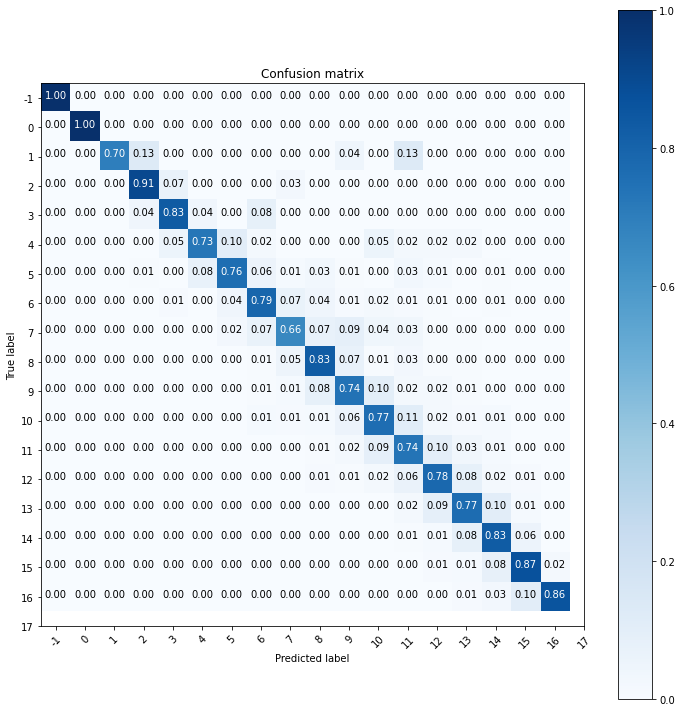

In [94]:


#print(df_test_draws)
#print(df_test_mates)
#train_X_test, test_X_test, train_y_test, test_y_test = train_test_split(df_test_sorted_dropped.drop(columns = ["result"]), df_test_sorted_dropped.result, 
#                                                    test_size = 0.3, random_state= 420, stratify=df_test_sorted_dropped.result)
df_test_concat,prediction_test = get_predictions_fulldf(df_test_draws,df_test_mates,df_test_sorted_dropped,final_model)
# test_pred_test = final_model.predict(df_test_concat.drop(columns = ["result"]))
cm = confusion_matrix(df_test_concat.result, prediction_test)
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

In [90]:
final_model.score(df_test_sorted_dropped.drop(columns = ["result"]),df_test_sorted_dropped.result)

0.7889035667107002

In [96]:
from sklearn.ensemble import VotingClassifier

vr = VotingClassifier(estimators=[('entropy', DecisionTreeClassifier(criterion='entropy',random_state=42)), ('def', DecisionTreeClassifier(random_state=42))],
                       n_jobs = -1)
vr.fit(train_X,train_y)
vr.score(test_X,test_y)

0.7820343461030383

In [97]:
from sklearn.ensemble import BaggingClassifier

br = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',random_state=42),n_jobs = -1)
br.fit(train_X,train_y)
br.score(test_X,test_y)

0.7982638233628987

In [99]:
vc = VotingClassifier(estimators=[('br',br),('final',final_model)], n_jobs = -1)
vc.fit(train_X,train_y)
vc.score(test_X,test_y)

0.7841102094734855

In [104]:
br.score(df_test_sorted_dropped.drop(columns = ["result"]),df_test_sorted_dropped.result)

0.7927344782034346

[ 8 11  8 ... 13 12 13]


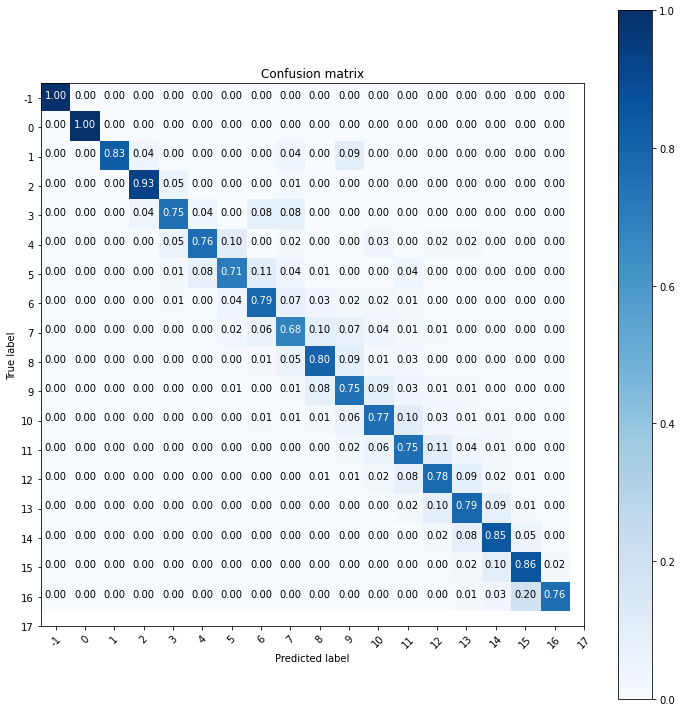

In [106]:
df_test_concat,prediction_test = get_predictions_fulldf(df_test_draws,df_test_mates,df_test_sorted_dropped,br)
# test_pred_test = final_model.predict(df_test_concat.drop(columns = ["result"]))
cm = confusion_matrix(df_test_concat.result, prediction_test)
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

In [107]:
from sklearn.metrics import r2_score

r2_score(df_concat.result,prediction)

0.9913418690036206

#### Wnioski
Wygląda na to, że zdecydowanie najlepiej spisuje się SVM z kernelem "rbf". Wobec tego zajmiemy się znalezieniem odpowiednich hiperparametrów używająć opytmalizacji bayesowskiej. (random search i grid search nie sprawdziły sie dobrze)

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Integer, Real

# #przykladowe
# model = svm.SVR(kernel="rbf")
# bayes = BayesSearchCV(model,search_spaces={
#     "C" : Integer(20,100),
#     "degree" : Integer(1,10),
#     "gamma" : Real(0,1),
#     "epsilon": Real(0,1)
# },n_jobs=-1,cv = 5)

# bayes.fit(train_X,train_y)

Użyliśmy optymalizacji bayesowskiej kilka razy na różne sposoby i otrzymaliśmy różne rezultaty jeśli chodzi o hiperparametry, lecz podobne wyniki score. Wobec tego wydaje się, że hiperparametry, oprócz "kernel", w tym przypadku nie mają dużego znaczenia.

In [ ]:
bayes1 = svm.SVR(kernel = 'rbf',C=41, degree=2, epsilon=0.5453896028447068, gamma=0.29095860195816414)
bayes2 = svm.SVR(kernel = 'rbf',C=30, degree=5, epsilon=0.1967759806539503, gamma=0.08869823764675565)
bayes3 = svm.SVR(kernel = 'rbf',C=20, degree=1, epsilon=0.2010835792844748, gamma=0.09924388919619698)

In [ ]:
bayes1.fit(train_X,train_y)
bayes2.fit(train_X,train_y)
bayes3.fit(train_X,train_y)

SVR(C=20, degree=1, epsilon=0.2010835792844748, gamma=0.09924388919619698)

Osiągają one na części testowej następujące wyniki: 

In [ ]:
print("bayes1:",bayes1.score(test_X,test_y),
      "\nbayes2:",bayes2.score(test_X,test_y),
      "\nbayes3:",bayes3.score(test_X,test_y),
      "\nsvr_rbf (sprawdzany wcześniej):", svr_rbf.score(test_X,test_y))

bayes1: 0.8852200880067526 
bayes2: 0.8978267260903322 
bayes3: 0.8982945547176829 
svr_rbf (sprawdzany wcześniej): 0.8958745147446084


Widać, że trzy ostatnie sobie dobrze radzą i są między nimi nieznaczne różnice.

In [ ]:
from sklearn.ensemble import VotingRegressor

vr = VotingRegressor(estimators=[('b2', bayes2), ('b3', bayes3), ('def', svr_rbf)],
                       n_jobs = -1)
vr.fit(train_X,train_y)
vr.score(test_X,test_y)

0.8982999400322259

In [ ]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(base_estimator=bayes2,n_jobs = -1)
br.fit(train_X,train_y)
br.score(test_X,test_y)

0.8997046089558998

Ensablingi też dużo nie zmieniły, chociaż BaggingRegressor pozwolił otrzymać najlepszy do tej pory wynik. Wobec tego ostatecznie będzie wykorzystywany.

## Wyniki

Zgarniając naszą ramkę danych w całość (to znaczy z powrotem łącząc remisy z resztą), otrzymamy ostateczny wynik score naszego modelu.

In [ ]:
def get_predictions_fulldf(df_draws,df_mates,df_sorted_dropped,estimator):
    # 
    regr_pred = estimator.predict(df_sorted_dropped.drop(columns="result"))
    draws = np.ones(df_draws.shape[0])*-1 #-1 oznaczało u nas wcześniej draw
    mates = np.zeros(df_mates.shape[0])
    prediction = np.concatenate((draws,mates,regr_pred))
    df_concat = pd.concat([df_draws,df_mates,df_sorted_dropped])
    return df_concat,prediction

df_concat,prediction = get_predictions_fulldf(df_draws,df_mates,df_sorted_dropped,br)

In [ ]:
from sklearn.metrics import r2_score

r2_score(df_concat.result,prediction)

0.9757650280975326

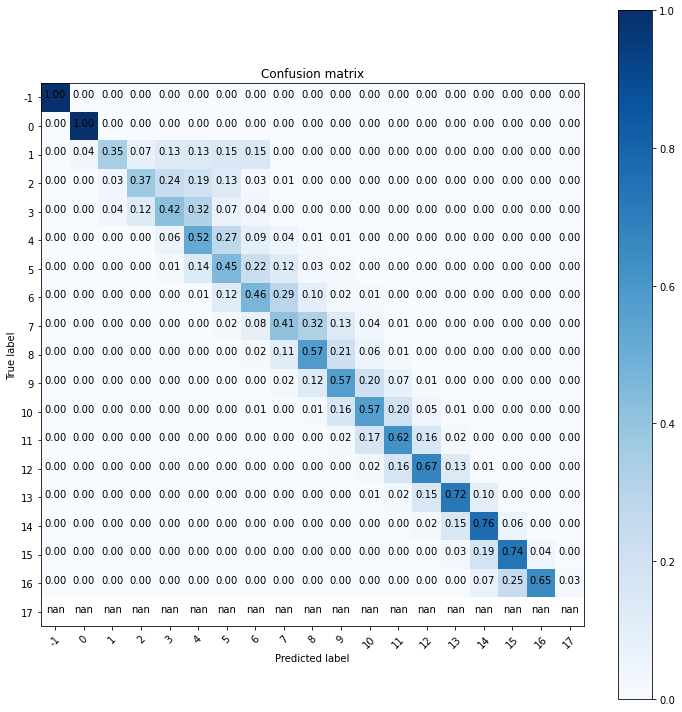

In [ ]:
# source kodu: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(df_concat.result, np.round(prediction))
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

Widać, że najczęściej nasz model myli się dla małych wartości. Podejrzewamy, że jest tak dlatego, że jest ich stosunkowo mało, więc po prostu nie rozpoznaje ich najlepiej.

In [ ]:
df_concat.result.value_counts()

 14    3187
 13    2936
 12    2518
 11    1998
-1     1957
 15    1516
 10    1389
 9     1198
 8     1003
 7      478
 6      414
 5      330
 16     273
 2      172
 4      139
 3       57
 1       55
 0       19
Name: result, dtype: int64

## Podsumowanie
*   Użyliśmy na zbiorze funkcji **w2r_rt**, która dodała dwie nowe kolumny, informujące o odległości białego króla od białej wieży, a także o tym czy wieża zostanie zbita.
*   Ufało nam się z całkowitą pewnością przewidzieć remisy i maty funkcjami **drawed** i **mated**. Wyniki są w kolumnach odpowiednio *is_draw* i *is_mated*.
*   Użyliśmy funkcji **drop_predicted_draws** do rozdzielenia zbioru, na dwa: 
    *   *df_draws* - zbiór, w którym ustalamy, że są same remisy
    *   *df_mates* - zbiór, w którym ustalamy, że jest już zamatowane
    *   *df_sorted_dropped* - zbiór, w którym przewidujemy, że nie będzie remisu, ani mata, i będziemy wykonywać dalszą predykcję
*   Sprawdziliśmy kilka modeli regresji w celu ustalenia liczby ruchów potrzebnych do mata. Ostatecznie najlepiej sprawdziły się modele SVM o hiperparametrze kernel = "rbf"
*   Przeprowadziliśmy optymalizację bayesowską, która znalazła troche lepsze parametry, ale nie zrobiło to większej różnicy.
*   Spróbowaliśmy ensemblingu, i wyszło, że _BaggingReggressor_ (nazwa zmiennej - **br**) używający naszego estymatora spisuje się nieco lepiej niż dotychczasowe modele
*   Używając funkcji **get_prediction_fulldf** łączymy rozdzielone wcześniej ramki danych i predykcje, a następnie liczymy ich score. 
